# Homework

In [151]:
#Handy imports from class

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import plotly.express as px
from scipy import signal

df = pd.read_csv('temperature.csv')

df.head(3)

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,309.100000,NaN,NaN,NaN
1,2012-10-01 13:00:00,284.630000,282.080000,289.480000,281.800000,291.870000,291.530000,293.410000,296.600000,285.120000,...,285.630000,288.220000,285.83000,287.170000,307.59,305.47,310.580000,304.4,304.4,303.5
2,2012-10-01 14:00:00,284.629041,282.083252,289.474993,281.797217,291.868186,291.533501,293.403141,296.608509,285.154558,...,285.663208,288.247676,285.83465,287.186092,307.59,304.31,310.495769,304.4,304.4,303.5


### 1. Write a function that efficiently converts every column to a different temperature scale

In [152]:
df['datetime'] = pd.to_datetime(df['datetime'])

#creating a new dataframe and performing a conversion from K to C by subtracting 273.15 from original T values
dfC = df.loc[ : , df.columns != 'datetime']-273.15

#Since the above operation removes the datetime column (so as not to try to do math on it), here I'm adding
#it back into my new dataframe at an index position of 0
dfC.insert(0, 'datetime', df['datetime'])

#printing the first 3 lines of the new dataframe to confirm everything is working as suspected
dfC.head(3)



,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,35.950000,NaN,NaN,NaN
1,2012-10-01 13:00:00,11.480000,8.930000,16.330000,8.650000,18.720000,18.380000,20.260000,23.450000,11.970000,...,12.480000,15.070000,12.68000,14.020000,34.44,32.32,37.430000,31.25,31.25,30.35
2,2012-10-01 14:00:00,11.479041,8.933252,16.324993,8.647217,18.718186,18.383501,20.253141,23.458509,12.004558,...,12.513208,15.097676,12.68465,14.036092,34.44,31.16,37.345769,31.25,31.25,30.35


In [153]:
#This question could be interpreted in more than one way. You can either just do the math on everything
#OR you could actually write a function to perform the specified operation.

def K_to_C(t):
    K_to_C = t - 273.15
    return K_to_C

#Now, to apply this to our dataframe:


### 2. Write a function that efficiently fills in missing values in every column, except for trailing NANs.  

That is: if there's temperature data on either side of a timestamp, it should interpolate through it. But if data stopped being collected, your function should leave nans at the end

In [178]:
#x is time stamps, xp is x's for existing records, fp is y's for xps
#Grabbing dates of interest
x = dfC['datetime']
#print("x", x.shape)



interpolated = pd.DataFrame({'datetime':x})
for i in dfC.columns:
    if i != 'datetime':
        knowns = dfC.loc[~dfC[i].isnull(), ['datetime',i]]
        xp = knowns['datetime']
        #print('xp', xp.shape)
        fp = np.array(knowns[i])
        #print('fp', fp.shape)
        #q=np.interp(x, xp, fp)
        #print("q",q.shape)
        #inserting the interpolated data into my dataframe; left and right values set so as to leave trailing NaNs
        interpolated.insert(len(interpolated.columns), i , np.interp(x, xp, fp, left=np.nan, right=np.nan))
        
#Looking at the tail of the new data table-check to see if trailing NaN are left
interpolated.tail(100)

#test = pd.DataFrame({'datetime':x, i: np.interp(x, xp, fp)})
#test


#x = df['datetime']
#xp_fp=[]
#print(x.shape)
#print(dfC.columns)
#for i in dfC.columns:
#i='Vancouver'
#print(i)
#knowns = df.loc[~df[i].isnull(), ['datetime',i]]
#xp = knowns['datetime']
#print(xp.shape)
#fp = np.array(knowns[i])
#print(fp.shape)
    
#interpolated = pd.DataFrame({'datetime':x, i:np.interp(x,xp,fp)})

#x is time stamps, xp is x's for existing records, fp is y's for xps
#Grabbing dates of interest
#x = df['datetime']
#Pull Vancouver times that are not null then run the interpolation
#knowns = df.loc[~df['Vancouver'].isnull(), ['datetime','Vancouver']]
#xp = knowns['datetime']
#fp = np.array(knowns['Vancouver'])

#test = pd.DataFrame({'datetime':x, 'Vancouver': np.interp(x, xp, fp)})

TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

### 3. Find cities A and B where city A is warmer than city B in the summer, but also colder than city B in the winter, on average

In [170]:
# Need to define season. Since this is a weather dataset, I chose to use the convention for meteorological seasons.
#By that, I mean that I chose December/January/February (DJF) as "winter" and June/July/August (JJA) as "summer" 
#with the assumption that all cities are Northern Hemisphere (data on latitude not given)
# To easily compare, I will make a new dataframe that stores the season and the average temperature in each city for 
#each season.

#iterating through the rows to turn the datetime column into datetime objects. Pulling out months and then
#specifying season. Making list of corresponding meteorological seasons.
#from datetime import datetime
df_season=dfC
season = []

for m in dfC['datetime']:
    month = m.month
    if month == 12 or month == 1 or month == 2:
        season_code = 'winter'
    elif month == 3 or month == 4 or month == 5:
        season_code = 'spring'
    elif month == 6 or month == 7 or month == 8:
        season_code = 'summer'
    else:
        season_code = 'fall'
    season.append(season_code)
    
#df_season.insert(1, 'season', season)
df_season.head()

#Calculating seasonal averages for all cities
seasonal_averages = df_season.groupby('season').mean()
#print(seasonal_averages)

#Loop to compare cities
#Also, creating a list of city pairs that satisfy the given conditions 
        
city_pairs = []        
        
for cityA in seasonal_averages.columns:
    if cityA != 'datetime':
        for cityB in seasonal_averages.columns:
            if cityB != 'datetime' and cityA != cityB:
                if seasonal_averages[cityA]['winter'] < seasonal_averages[cityB]['winter'] and seasonal_averages[cityA]['summer'] > seasonal_averages[cityB]['summer']:
                    city_pairs.append((cityA, cityB))
print(city_pairs)

#Below can be used as a check to make sure the number of city pairs returned is reasonable
#print('number', len(city_pairs))


#Finally, since I need to look at 2 cities in the next question, I looked at my list and chose:
#City A = New York
#City B = Los Angeles
                 

[('Portland', 'San Francisco'), ('Portland', 'Seattle'), ('Las Vegas', 'San Francisco'), ('Las Vegas', 'Los Angeles'), ('Las Vegas', 'San Diego'), ('Las Vegas', 'San Antonio'), ('Las Vegas', 'Dallas'), ('Las Vegas', 'Houston'), ('Las Vegas', 'Jacksonville'), ('Las Vegas', 'Miami'), ('Las Vegas', 'Beersheba'), ('Las Vegas', 'Tel Aviv District'), ('Las Vegas', 'Eilat'), ('Las Vegas', 'Haifa'), ('Las Vegas', 'Nahariyya'), ('Las Vegas', 'Jerusalem'), ('Phoenix', 'Los Angeles'), ('Phoenix', 'San Diego'), ('Phoenix', 'San Antonio'), ('Phoenix', 'Houston'), ('Phoenix', 'Jacksonville'), ('Phoenix', 'Miami'), ('Phoenix', 'Tel Aviv District'), ('Phoenix', 'Eilat'), ('Phoenix', 'Haifa'), ('Phoenix', 'Nahariyya'), ('Phoenix', 'Jerusalem'), ('Albuquerque', 'Vancouver'), ('Albuquerque', 'Portland'), ('Albuquerque', 'San Francisco'), ('Albuquerque', 'Seattle'), ('Albuquerque', 'Los Angeles'), ('Albuquerque', 'San Diego'), ('Denver', 'Vancouver'), ('Denver', 'Portland'), ('Denver', 'San Francisco'), (

### 4. For the two cities you found in for problem 4 (there are many possible answers), clean up the data via aggregation or rolling averages and plot a clear visual

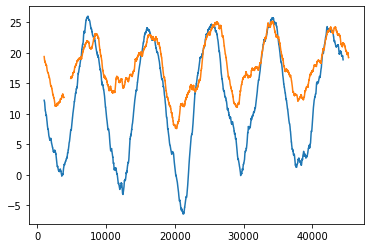

In [175]:
#px.line(dfC.groupby('date').agg({'New York':'mean'}).reset_index(), x='day', y='New York')
plt.plot(dfC['New York'].rolling(1000).mean())

#px.line(dfC.groupby('datetime').agg({'Los Angeles':'mean'}).reset_index(), x='date', y='Los Angeles')
plt.plot(dfC['Los Angeles'].rolling(1000).mean())



### Note: The summer max temperatures are very similar for both cities; the variability is truly coming from the winter temperatures here.

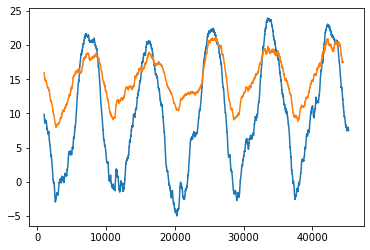

In [176]:
#px.line(dfC.groupby('date').agg({'New York':'mean'}).reset_index(), x='day', y='New York')
plt.plot(dfC['Denver'].rolling(1000).mean())

#px.line(dfC.groupby('datetime').agg({'Los Angeles':'mean'}).reset_index(), x='date', y='Los Angeles')
plt.plot(dfC['San Francisco'].rolling(1000).mean())


### Since my past pairing had very similar summer temperatures, I wanted to look at some extra city pairs. Here, you can see that there is and enhanced summer temperature difference also with a large winter temperature difference.

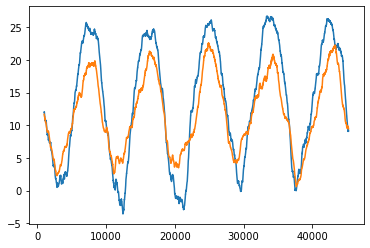

In [177]:
#px.line(dfC.groupby('date').agg({'New York':'mean'}).reset_index(), x='day', y='New York')
plt.plot(dfC['Saint Louis'].rolling(1000).mean())

#px.line(dfC.groupby('datetime').agg({'Los Angeles':'mean'}).reset_index(), x='date', y='Los Angeles')
plt.plot(dfC['Portland'].rolling(1000).mean())


### Finally, I decided to look at 2 cities where I knew there were likely larger summer temperature differences. Here, I looked at St. Louis and Portland. The range of temperatures for these 2 cities are more similar than for the previous 2 pairs but you can clearly see both the winter and summer T differences.

### If I were really trying to look at this data to identify differences between cities, I would probably try to include some additional conditions to filter the city pairs list. For example, maybe look at statistically significant differences in temperature averages in the 2 cities or impose a cutoff value in some other way for the minimum value of the differences between the temperatures in the 2 cities.